### 一.运行机制
为了更加高效的运行GNN，我们可以利用一些高效的图计算框架帮助我们训练模型，DGL（Deep Graph Library）便是一种比较方便的框架，它将所有的图计算过程拆分为了三个基本部分，分别介绍如下：   

**1.1 消息传递函数**  
该函数是将一条边以及与其关联的两个节点的信息进行聚合，然后将聚合后**消息**重新赋值到边上，可以用如下的表达式抽象表达：   

$$
m_{uv}^{(t+1)}=\phi(x_u^{(t)},x_v^{(t)},w_{uv}^{(t)})
$$  

其中，$w_{uv}^{(t)}$表示边$(u,v)$上的特征，$x_u^{(t)}$表示节点$u$上的特征，$x_v^{(t)}$表示节点$v$上的特征  

**1.2 聚合函数**   
聚合函数是将与训练节点关联的边上的消息，进行聚合：    

$$
\rho_u^{t+1}=\rho(\{m_{uk}^{(t+1)}\mid k\in N(u)\})
$$  

这里，$N(u)$表示与节点$u$相连的邻居节点   

**1.3 更新函数**  
更新函数的作用是将聚合特征与节点的旧特征进行聚合，然后生成节点的新特征：   

$$
x_u^{(t+1)}=\varphi(x_u^{(t)},\rho_u^{t+1})
$$   

我们之前介绍的GCN，GAT，GraphSAGE便可分解为这三个基本操作函数，接下来我利用DGL库演示一下这3个基本操作

### 二.实践  

**2.1 构图**：首先构建一张图，并为节点和边赋值

In [1]:
import dgl
import torch

Using backend: pytorch


In [2]:
u=torch.tensor([0,0,0,0,1,1,2,3,2,4,5,5,6,6,6,7,8])
v=torch.tensor([1,2,3,4,2,3,4,4,5,5,6,7,7,8,9,8,9])
g=dgl.graph((u,v))

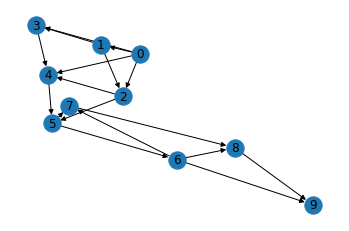

In [3]:
#转换为networkx可视化
%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx
plt.axis("off")
nx.draw_networkx(g.to_networkx())
plt.show()

In [4]:
#分别为节点和边赋值一个三维的向量
g.ndata["nx"]=torch.randn(g.num_nodes(),3)
g.edata["ex"]=torch.randn(g.num_edges(),3)

In [5]:
#查看
g.ndata["nx"],g.edata["ex"]

(tensor([[ 0.6239,  0.3987, -0.6238],
         [-0.7141, -1.0818, -1.0757],
         [-0.0540,  1.1078,  0.2700],
         [ 0.5681, -1.0023, -1.4963],
         [-1.3526, -0.5072,  0.3111],
         [ 0.4039,  0.1909,  2.4836],
         [ 0.2190,  0.9467, -0.6446],
         [-0.5860, -1.7527, -1.0872],
         [ 0.8450,  0.9458, -0.5495],
         [ 1.3140,  0.4514,  0.5442]]),
 tensor([[-0.5180, -0.1497,  0.4278],
         [ 0.7970, -0.1222, -0.5810],
         [-0.9885,  0.7971, -1.0056],
         [-0.5377,  0.3229, -0.1410],
         [ 1.2062,  1.3272, -0.4768],
         [-0.6856,  0.9685, -1.3733],
         [ 1.0140, -0.1059,  1.4300],
         [-0.4088,  0.5824, -0.4151],
         [ 1.4490, -1.0892,  0.2116],
         [ 0.2986, -0.0652, -0.4363],
         [ 0.7020,  0.6645, -1.1004],
         [ 0.7326,  0.5491,  0.8222],
         [-0.5815, -1.3774,  0.7640],
         [ 1.1323, -1.4232,  0.2073],
         [-0.3632, -1.3108, -1.2507],
         [-0.7597, -1.1140,  0.2626],
         [

**2.2 利用apply_edges进行消息传递**  

apply_edges可以完成第一个函数的操作，即将两节点特征和边特征进行某种操作，然后将结果保存回边上，我们先用dgl自带的api，将$u,v$节点的特征相加然后赋值到边上

In [6]:
g.apply_edges(dgl.function.u_add_v("nx","nx","add_x"))#第一个nx表示u上的nx特征，第二个表示v上的nx特征，add_x表示赋值到边上的特征
g.edata["add_x"]

tensor([[-0.0902, -0.6831, -1.6995],
        [ 0.5699,  1.5065, -0.3538],
        [ 1.1919, -0.6036, -2.1202],
        [-0.7288, -0.1085, -0.3128],
        [-0.7681,  0.0260, -0.8057],
        [-0.1461, -2.0841, -2.5721],
        [-1.4066,  0.6007,  0.5811],
        [-0.7846, -1.5095, -1.1853],
        [ 0.3500,  1.2987,  2.7536],
        [-0.9487, -0.3163,  2.7946],
        [ 0.6229,  1.1375,  1.8389],
        [-0.1821, -1.5618,  1.3964],
        [-0.3670, -0.8060, -1.7318],
        [ 1.0640,  1.8925, -1.1941],
        [ 1.5330,  1.3981, -0.1005],
        [ 0.2589, -0.8069, -1.6367],
        [ 2.1590,  1.3972, -0.0053]])

这个过程也可以写自定义函数进行操作

In [7]:
def message_func(edges):
     return {'new_add_x': edges.src['nx'] + edges.dst['nx']}

In [8]:
g.apply_edges(message_func)
g.edata["new_add_x"]

tensor([[-0.0902, -0.6831, -1.6995],
        [ 0.5699,  1.5065, -0.3538],
        [ 1.1919, -0.6036, -2.1202],
        [-0.7288, -0.1085, -0.3128],
        [-0.7681,  0.0260, -0.8057],
        [-0.1461, -2.0841, -2.5721],
        [-1.4066,  0.6007,  0.5811],
        [-0.7846, -1.5095, -1.1853],
        [ 0.3500,  1.2987,  2.7536],
        [-0.9487, -0.3163,  2.7946],
        [ 0.6229,  1.1375,  1.8389],
        [-0.1821, -1.5618,  1.3964],
        [-0.3670, -0.8060, -1.7318],
        [ 1.0640,  1.8925, -1.1941],
        [ 1.5330,  1.3981, -0.1005],
        [ 0.2589, -0.8069, -1.6367],
        [ 2.1590,  1.3972, -0.0053]])

**2.3 利用update_all组合消息传递函数与聚合函数**  

update_all将消息传递和聚合函数一并进行操作，下面演示先将邻居节点特征加到边，然后再将边特征加到节点

In [9]:
g.update_all(dgl.function.u_add_v("nx","nx","add_x"),
             dgl.function.sum("add_x","add_edge_x"))
g.ndata["add_edge_x"]

tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.0902, -0.6831, -1.6995],
        [-0.1982,  1.5326, -1.1595],
        [ 1.0459, -2.6876, -4.6922],
        [-2.9200, -1.0173, -0.9170],
        [-0.5987,  0.9824,  5.5482],
        [ 0.6229,  1.1375,  1.8389],
        [-0.5491, -2.3679, -0.3355],
        [ 1.3229,  1.0856, -2.8309],
        [ 3.6919,  2.7953, -0.1058]])

当然，也可以自定义

In [10]:
def reduce_func(nodes):
     return {'new_add_edge_x': torch.sum(nodes.mailbox['add_x'], dim=1)}

In [11]:
g.update_all(dgl.function.u_add_v("nx","nx","add_x"),
             reduce_func)
g.ndata["new_add_edge_x"]

tensor([[ 0.0000,  0.0000,  0.0000],
        [-0.0902, -0.6831, -1.6995],
        [-0.1982,  1.5326, -1.1595],
        [ 1.0459, -2.6876, -4.6922],
        [-2.9200, -1.0173, -0.9170],
        [-0.5987,  0.9824,  5.5482],
        [ 0.6229,  1.1375,  1.8389],
        [-0.5491, -2.3679, -0.3355],
        [ 1.3229,  1.0856, -2.8309],
        [ 3.6919,  2.7953, -0.1058]])

**2.3 更新函数：最后组合聚合特征和原特征**   
这部分操作就很容易了，因为聚合特征和原特征都在节点上了，所以我们直接操作即可，比如相加

In [12]:
g.ndata["nx"]

tensor([[ 0.6239,  0.3987, -0.6238],
        [-0.7141, -1.0818, -1.0757],
        [-0.0540,  1.1078,  0.2700],
        [ 0.5681, -1.0023, -1.4963],
        [-1.3526, -0.5072,  0.3111],
        [ 0.4039,  0.1909,  2.4836],
        [ 0.2190,  0.9467, -0.6446],
        [-0.5860, -1.7527, -1.0872],
        [ 0.8450,  0.9458, -0.5495],
        [ 1.3140,  0.4514,  0.5442]])

In [13]:
g.ndata["nx"]=g.ndata["nx"]+g.ndata["add_edge_x"]
g.ndata["nx"]#注意从第二行开始看

tensor([[ 0.6239,  0.3987, -0.6238],
        [-0.8044, -1.7649, -2.7753],
        [-0.2522,  2.6404, -0.8895],
        [ 1.6139, -3.6899, -6.1886],
        [-4.2726, -1.5244, -0.6059],
        [-0.1948,  1.1733,  8.0318],
        [ 0.8419,  2.0842,  1.1943],
        [-1.1352, -4.1206, -1.4227],
        [ 2.1679,  2.0314, -3.3804],
        [ 5.0059,  3.2467,  0.4384]])

下一节，让我们用PageRank来练练手~